**PyTorchニューラルネットワーク実装ハンドブック**

**3-1. 基本的なニューラルネットワークを使った画像分類**

	MLPネットワークでの画像分類をPyTorchで実装する際のステップ
	
	1. データ読み込み
	2. ネットワーク定義
	3. 損失関数
	4. 最適化関数
	5. 学習
	6. 推論

In [0]:
#colabを使う方はこちらを使用ください。
#!pip install torch==0.4.1
#!pip install torchvision==0.2.1
#!pip install numpy==1.14.6
#!pip install matplotlib==2.1.2
#!pip install pillow==5.0.0
#!pip install opencv-python==3.4.3.18

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# CIFAR-10をMLPで画像分類

## データの読み込み

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=False, 
                                             transform=transforms.ToTensor(),
                                             download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


ニューラルネットワークに入力するデータはTensorにする必要がある。

CIFAR-10のデータセットを取得するとPyTorchのTensor型になっていることが確認できる。

train_datasetには画像と正解ラベルのデータのペアのリストが格納されている。

train_datasetの1個目のデータに対してsize()を使用してTensorの形状を表示しています。

CIFAR-10は32X32、RGB3チャンネルなので、(3, 32, 32)の形状となり、取り出した最初の画像は正解ラベルが6であることを示している。

**CIFAR-10の特徴**
* 80 million tiny imagesのサブセット
* 全部で60000枚
* 画像サイズは32ピクセルx32ピクセル
* RGBの3チャンネルカラー画像
* クラスラベルはairplane, automobile, bird, cat, deer, dog, frog, horse, ship, truckで10クラス
* 50000枚（各クラス5000枚）の訓練画像と10000枚（各クラス1000枚）のテスト画像に分割されている
* クラスラベルは排他的
* PythonのcPickle形式で提供されている



In [4]:
image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
6


In [0]:
# PyTorchでデータを読み込むにはDataSetと、DataLoaderを使うと便利。
# Datasetが画像と正解ラベルのペアを返却する。
# DataLoaderはバッチサイズだけの画像と正解ラベルをDataSetから取り出す。
# batch_sizeを64にしている。バッチサイズごとにまとまったデータを返しながら学習や検証のコードを書いていく。

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=2)

In [6]:
#i = 0
for images, labels in train_loader:
    print(images.size())
    print(images[0].size())
    print(labels.size())
    #print(i)
    #i = i+1
    # ここに訓練用のコードを書く
    break

torch.Size([64, 3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([64])


### 分類問題の正解ラベル  
分類問題を扱うとき正解ラベルのカテゴリカル変数はワンホット形式に変換する必要はない。  
ただし、ネットワークの出力ユニット数はクラス数にする必要がある。  


## ネットワークを定義  

* nn.Moduleを継承したMLPネットワークを定義
* 隠れ層のユニット数は600。
* 隠れ層にドロップアウトを適用
* GPUが使える環境か確認

In [0]:

num_classes = 10

class MLPNet (nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 600)
        self.fc2 = nn.Linear(600, 600)
        self.fc3 = nn.Linear(600, num_classes)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return F.relu(self.fc3(x))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MLPNet().to(device)

## 損失関数と最適化関数

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

## 訓練

In [9]:
#50エポック
num_epochs = 50

#最後にlossとaccuracyのグラフをプロットするためのリスト
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    #エポックごとに初期化
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train==============================
    #訓練モードへ切り替え
    net.train()
    #ミニバッチで分割して読み込む
    for i, (images, labels) in enumerate(train_loader):
      #viewで縦横32ピクセルで3チャンネルの画像を１次元に変換
      #toでgpuに転送
      images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)

      #勾配をリセット
      optimizer.zero_grad()
      #順伝播の計算
      outputs = net(images)
      #lossの計算
      loss = criterion(outputs, labels)
      #lossのミニバッチ分を溜め込む
      train_loss += loss.item()
      #accuracyをミニバッチ分を溜め込む
      #正解ラベル（labels）と予測値のtop1（outputs.max(1)）が合っている場合に1が返ってきます。
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      #逆伝播の計算
      loss.backward()
      #重みの更新
      optimizer.step()
    #平均lossと平均accuracyを計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val==============================
    #評価モードへ切り替え
    net.eval()
    #評価するときに必要のない計算が走らないようにtorch.no_gradを使用しています。
    with torch.no_grad():
      for images, labels in test_loader:        
        images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    #訓練データのlossと検証データのlossとaccuracyをログで出しています。
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    #最後にグラフをプロットするようにリストに格納
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/50], Loss: 0.0319, val_loss: 0.0280, val_acc: 0.3595
Epoch [2/50], Loss: 0.0277, val_loss: 0.0272, val_acc: 0.3774
Epoch [3/50], Loss: 0.0267, val_loss: 0.0256, val_acc: 0.4239
Epoch [4/50], Loss: 0.0258, val_loss: 0.0245, val_acc: 0.4463
Epoch [5/50], Loss: 0.0252, val_loss: 0.0254, val_acc: 0.4148
Epoch [6/50], Loss: 0.0247, val_loss: 0.0238, val_acc: 0.4563
Epoch [7/50], Loss: 0.0243, val_loss: 0.0237, val_acc: 0.4606
Epoch [8/50], Loss: 0.0239, val_loss: 0.0233, val_acc: 0.4668
Epoch [9/50], Loss: 0.0236, val_loss: 0.0236, val_acc: 0.4543
Epoch [10/50], Loss: 0.0234, val_loss: 0.0233, val_acc: 0.4596
Epoch [11/50], Loss: 0.0230, val_loss: 0.0223, val_acc: 0.4980
Epoch [12/50], Loss: 0.0228, val_loss: 0.0238, val_acc: 0.4506
Epoch [13/50], Loss: 0.0227, val_loss: 0.0224, val_acc: 0.4986
Epoch [14/50], Loss: 0.0223, val_loss: 0.0220, val_acc: 0.4964
Epoch [15/50], Loss: 0.0224, val_loss: 0.0221, val_acc: 0.4989
Epoch [16/50], Loss: 0.0221, val_loss: 0.0218, val_acc: 0.5006
E

## 結果をプロット

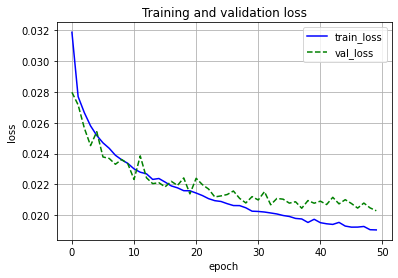

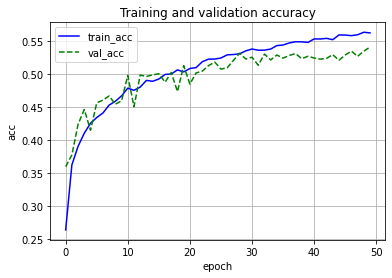

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

In [0]:
# ネットワークを保存する
torch.save(net.state_dict(), 'net.ckpt')

In [12]:
# ネットワークを読み込む
net2 = MLPNet().to(device)
net2.load_state_dict(torch.load('net.ckpt'))

<All keys matched successfully>

## 推論

In [13]:
net2.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
        images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)
        outputs = net2(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('精度: {} %'.format(100 * test_acc / total)) 

精度: 54.11 %


下図グラフを見ると、訓練終了時でも正解率は60%にも達していない。
CIFAR-10をMLPで分類するとあまりいい正解率にはなっていない。